In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import networkx as nx
import argparse
import random
import numpy as np
from tqdm import tqdm
import os

from nnc_snr import *

In [3]:
args = argparse.Namespace(epochs=50, batch_size=32, input_size=392, hidden_size=256, \
                          output_size=256, train_snr=40, val_snr=40, power=1, \
                        learning_rate=0.001, device='cuda:2', model_path='run1', \
                            dropout=False, test=False, scale_outputs=False,\
                                dataset='mnist')

# if args.device == 'cpu':
#     device = torch.device("cpu") 
# elif 'cuda' in args.device:
#     device = torch.device(args.device if torch.cuda.is_available() else "cpu")
# elif args.device == 'mps':
#     device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

device = torch.device("cuda:3")
train_sigma = snr_db2sigma(args.train_snr)
val_sigma = snr_db2sigma(args.val_snr)
test_snr = np.arange(-60, 60, 10)
test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])
if not args.scale_outputs:       
    eq_train_sigma = train_sigma / np.sqrt(args.power)  
    eq_val_sigma = val_sigma / np.sqrt(args.power)
    eq_test_sigma = test_sigma / np.sqrt(args.power)
    scale_power = 1
else:
    eq_train_sigma = train_sigma
    eq_val_sigma = val_sigma
    eq_test_sigma = test_sigma
    scale_power = args.power

In [4]:
if args.dataset == 'mnist':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'fashion':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'cifar10':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
elif args.dataset == 'stl10':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    train_dataset = torchvision.datasets.STL10(root='./data', split='train', transform=transform, download=True)
    test_dataset = torchvision.datasets.STL10(root='./data', split='test', transform=transform, download=True)


train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
sample_image, _ = train_dataset[0]
input_size = sample_image.size(2)*sample_image.size(1)*sample_image.size(0) // 2
model = ButterflyNetwork(input_size, args.hidden_size, args.output_size, eq_train_sigma, scale_power).to(device)
    


In [15]:
model_path = 'models/nrun1_snr_0/model.pt'


In [17]:

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    # snr_range = np.arange(0, 60, 10)
    result = test(model, test_loader, eq_test_sigma, device)
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

    result = test_dropped(model, test_loader, eq_test_sigma, device, ['AE'])
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
else:
    print(f"No model found at {model_path}")

Loaded model:
 SNR range: (-60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0)
 Test Loss: 1229.9182, 125.9229, 13.9019, 1.8028, 0.2295, 0.0508, 0.0335, 0.0318, 0.0317, 0.0316, 0.0316, 0.0316
 Test PSNR: -21.8892, -11.9915, -2.4212, 6.4501, 15.4021, 21.9499, 23.7541, 23.9821, 24.0057, 24.0078, 24.0081, 24.0081
Loaded model:
 SNR range: (-60.0, -50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0, 50.0)
 Test Loss: 1224.0912, 124.7069, 13.8262, 1.9900, 0.5178, 0.3538, 0.3374, 0.3358, 0.3357, 0.3356, 0.3356, 0.3356
 Test PSNR: -21.8686, -11.9493, -2.3975, 6.0210, 11.8675, 13.5216, 13.7278, 13.7482, 13.7506, 13.7509, 13.7509, 13.7509


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.0592, 0.0495, 0.0494
 Test PSNR: 21.2879, 22.0610, 22.0694


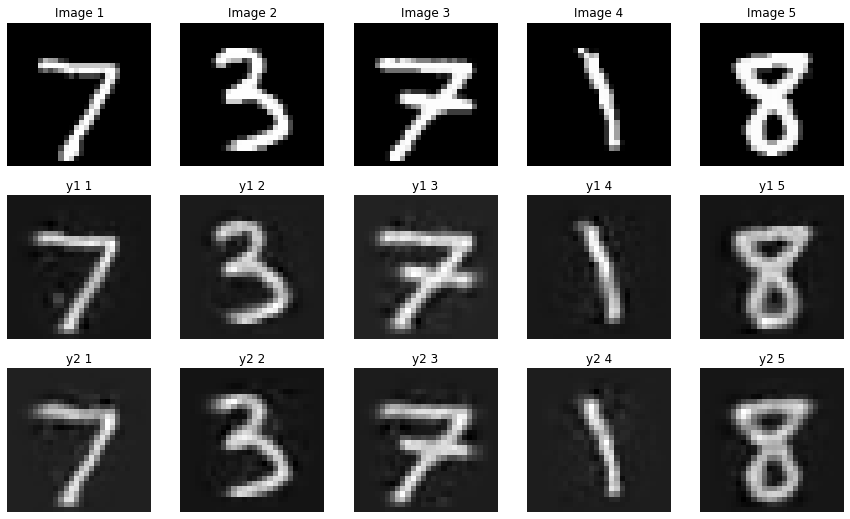

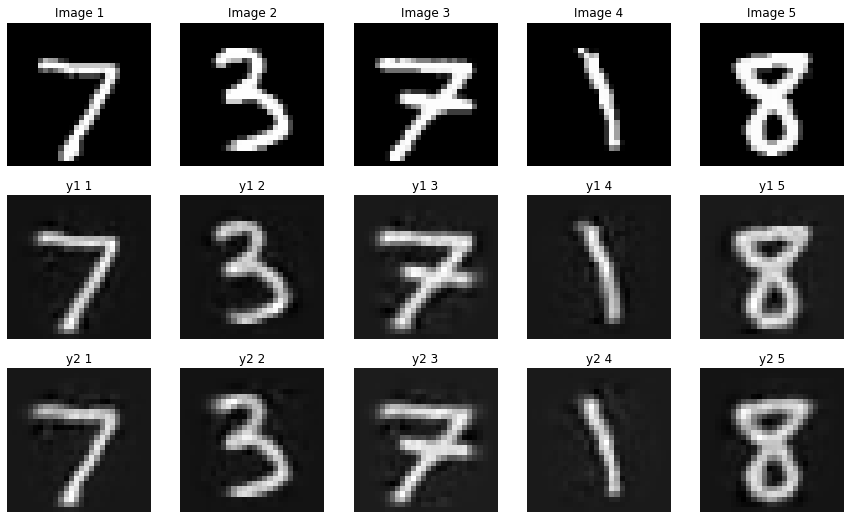

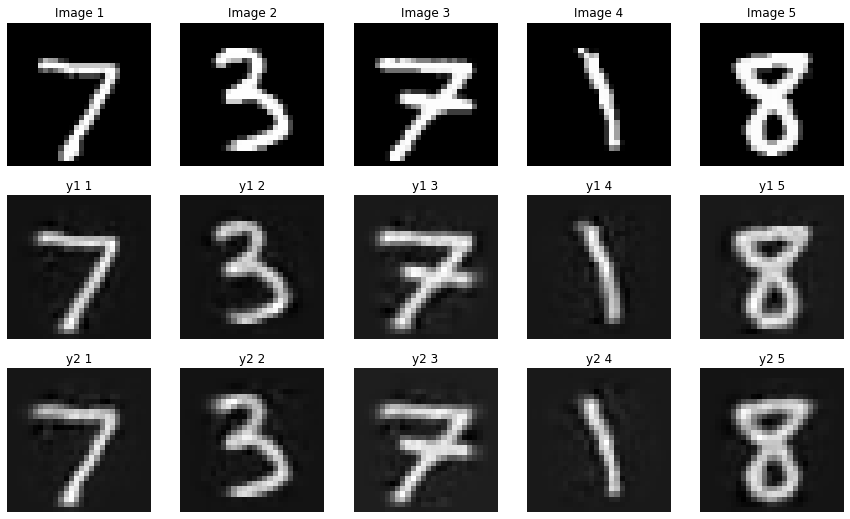

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/nrun1_snr_-20/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.2292, 0.0335, 0.0316
 Test PSNR: 15.4083, 23.7547, 24.0081


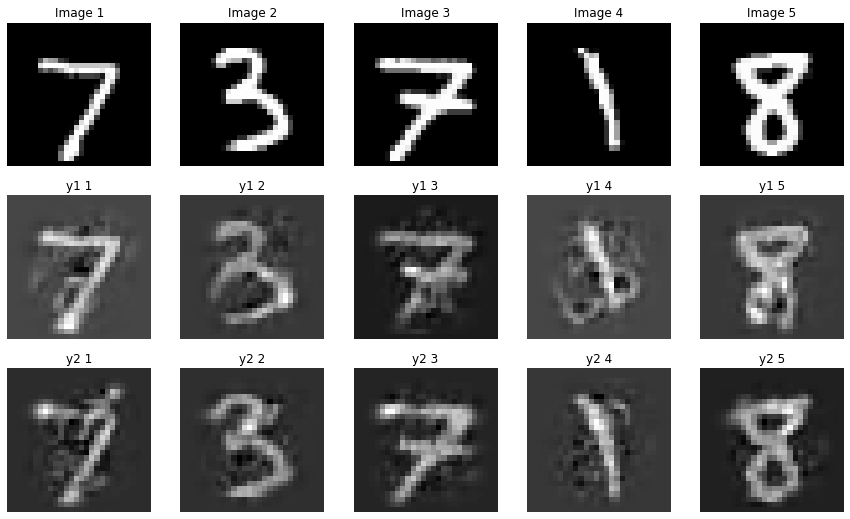

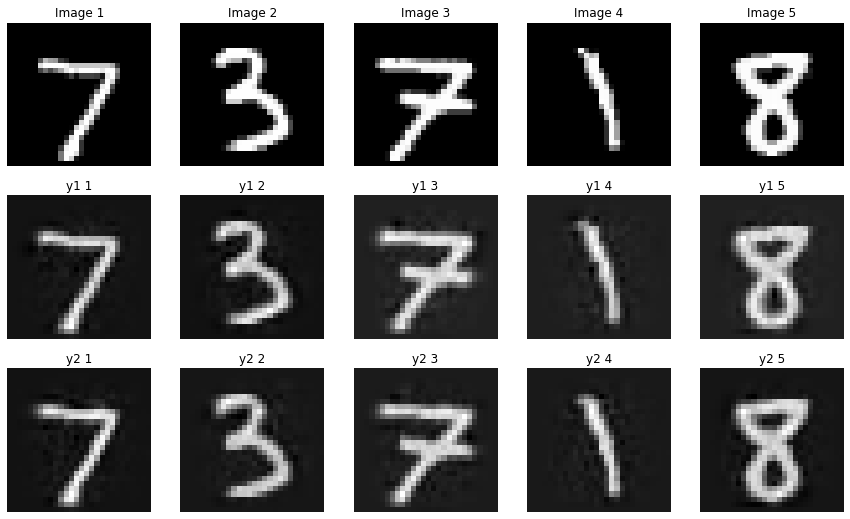

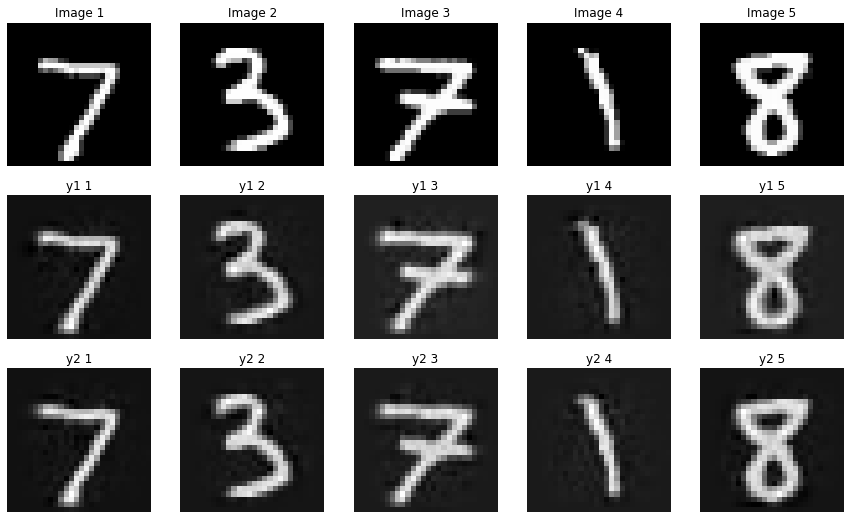

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/nrun1_snr_0/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 16.0133, 0.4490, 0.0302
 Test PSNR: -3.0353, 12.4866, 24.2131


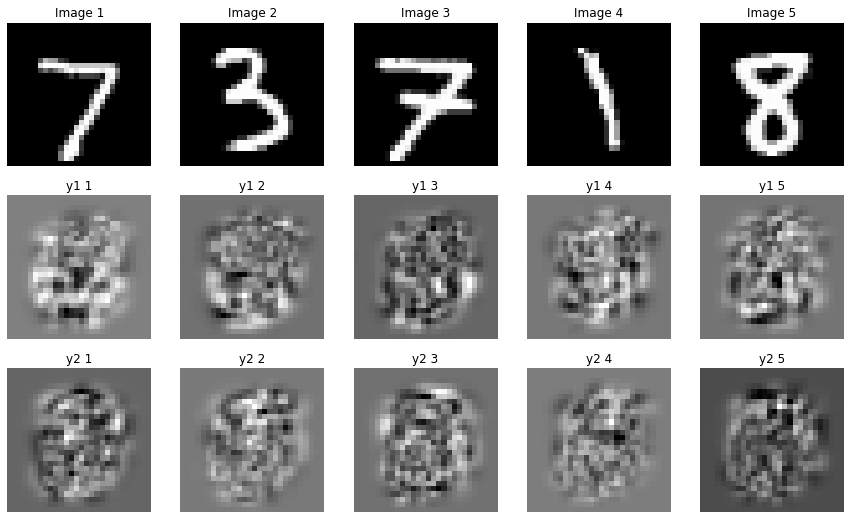

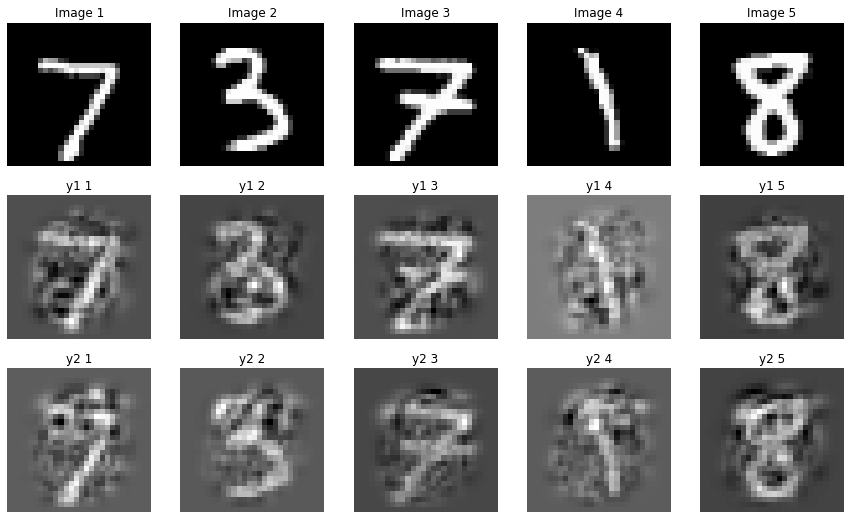

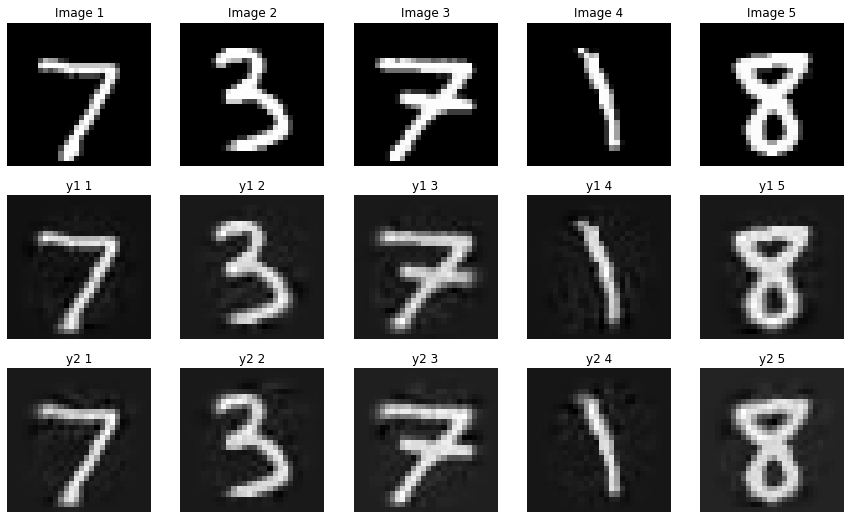

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/nrun1_snr_40/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (40.0, 20.0, 0.0, -20.0)
 Test Loss: 0.0302, 0.0344, 0.4504, 16.0524
 Test PSNR: 24.2132, 23.6449, 12.4739, -3.0458


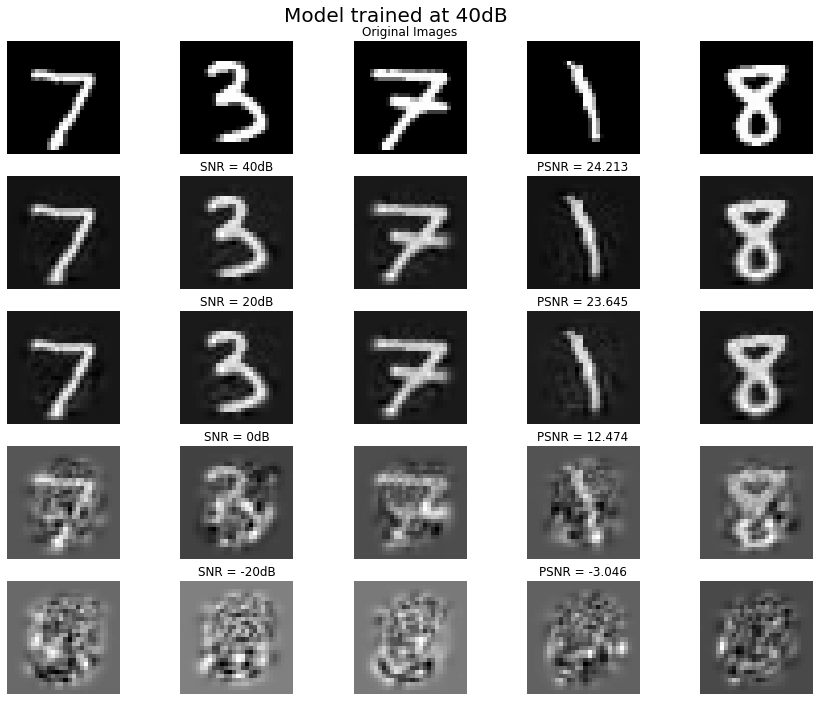

Loaded model:
 SNR range: (40.0, 20.0, 0.0, -20.0)
 Test Loss: 0.0299, 0.0303, 0.0760, 3.0437
 Test PSNR: 24.2550, 24.1896, 20.2028, 4.1756


<Figure size 432x288 with 0 Axes>

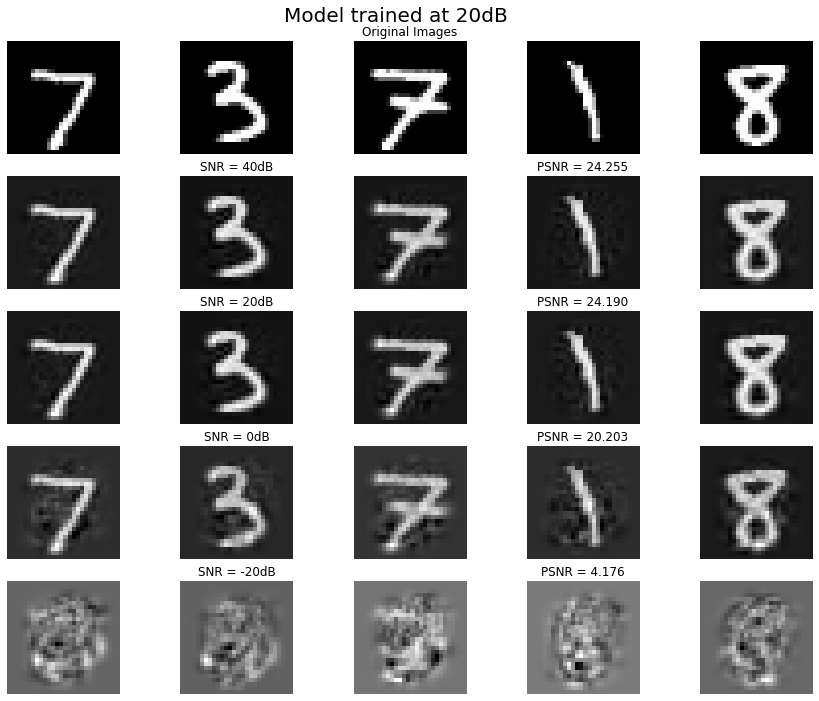

Loaded model:
 SNR range: (40.0, 20.0, 0.0, -20.0)
 Test Loss: 0.0316, 0.0317, 0.0335, 0.2290
 Test PSNR: 24.0081, 24.0056, 23.7546, 15.4103


<Figure size 432x288 with 0 Axes>

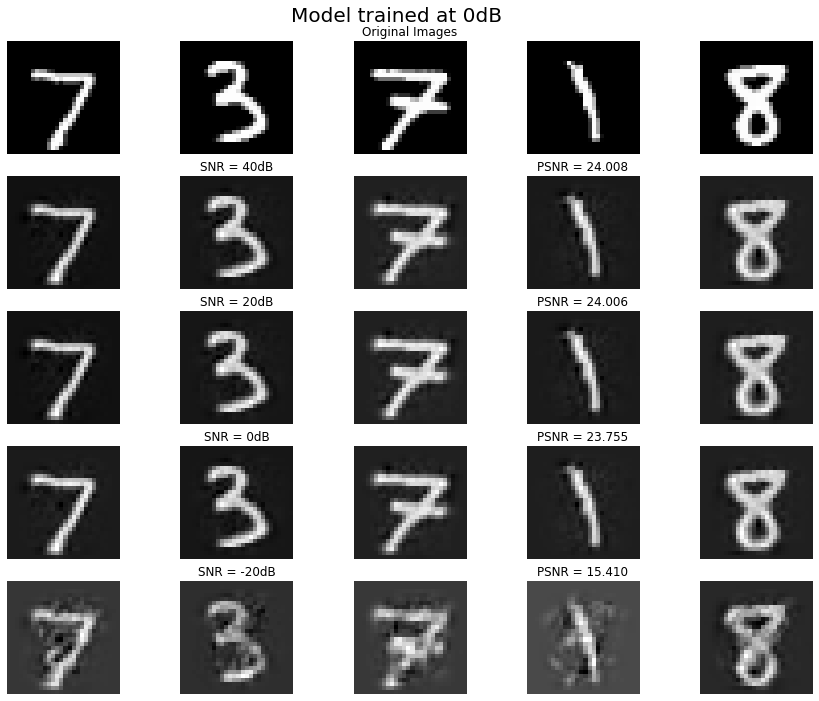

Loaded model:
 SNR range: (40.0, 20.0, 0.0, -20.0)
 Test Loss: 0.0494, 0.0494, 0.0495, 0.0592
 Test PSNR: 22.0694, 22.0693, 22.0607, 21.2859


<Figure size 432x288 with 0 Axes>

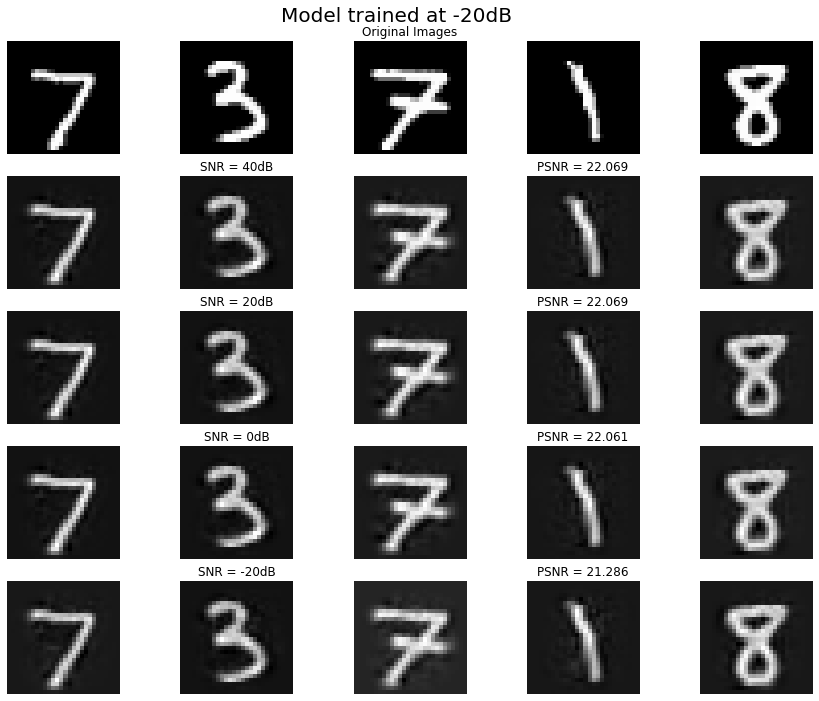

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [40, 20, 0, -20]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

for train_snr in [40, 20, 0, -20]:
    model_path = f'models/nrun1_snr_{train_snr}/model.pt'
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    result = test(model, test_loader, eq_test_sigma, device)
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s_40dB = []
    sample_y1s_20dB = []
    sample_y1s_0dB = []
    sample_y1s_m20dB = []

    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        sample_images.append(to_numpy_image(images[0]))

        for snr, sample_y1s in zip(test_snr, [sample_y1s_40dB, sample_y1s_20dB, sample_y1s_0dB, sample_y1s_m20dB]):
            sigma = snr_db2sigma(snr)
            y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
            sample_y1s.append(to_numpy_image(y1[0]))

    # Visualize the images on a 4x5 grid
    fig, axes = plt.subplots(5, 5, figsize=(15, 12))

    fig.suptitle(f'Model trained at {train_snr}dB', fontsize=20, y=0.92)

    snr_labels = ['Original Images', 'SNR = 40 dB', 'SNR = 20 dB', 'SNR = 0 dB', 'SNR = -20 dB']

    # for row, snr_label in enumerate(snr_labels):
    #     axes[row, 0].set_ylabel(snr_label, fontsize=14)
    # for row, x in enumerate(zip(snr_labels, [''] + [f"PSNR = {p:.3f}" for p in test_psnrs])):
    #     snr_label, psnr = x
    #     fig.text(-0.1, 1 - row * 0.19, f"{snr_label}: \n {psnr}", fontsize=14, ha='right', va='center')
    snr_labels = ['Original Images', 'SNR = 40 dB', 'SNR = 20 dB', 'SNR = 0 dB', 'SNR = -20 dB']
    psnr_labels = ['', *map(lambda x: f"PSNR = {x:.3f}", test_psnrs)]

    for row, (snr_label, psnr_label) in enumerate(zip(snr_labels, psnr_labels)):
        axes[row, 0].set_ylabel(f"{snr_label}\n{psnr_label}", fontsize=14, labelpad=15)


    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        if i == 2:
            axes[0, i].set_title(f'Original Images', fontsize=12)
        # axes[0, i].set_title(f'Original Image {i+1}')

        axes[1, i].imshow(sample_y1s_40dB[i], cmap='gray')
        axes[1, i].axis('off')
        if i == 1:
            axes[1, i].set_title(f'SNR = 40dB', fontsize=12)
        if i == 3:
            axes[1, i].set_title(f'PSNR = {test_psnrs[0]:.3f}', fontsize=12)

        axes[2, i].imshow(sample_y1s_20dB[i], cmap='gray')
        axes[2, i].axis('off')
        if i == 1:
            axes[2, i].set_title(f'SNR = 20dB', fontsize=12)
        if i == 3:
            axes[2, i].set_title(f'PSNR = {test_psnrs[1]:.3f}', fontsize=12)
        # axes[2, i].set_title(f'Received Image {i+1} (SNR = 20dB)')

        axes[3, i].imshow(sample_y1s_0dB[i], cmap='gray')
        axes[3, i].axis('off')
        if i == 1:
            axes[3, i].set_title(f'SNR = 0dB', fontsize=12)
        if i == 3:
            axes[3, i].set_title(f'PSNR = {test_psnrs[2]:.3f}', fontsize=12)
        # axes[3, i].set_title(f'{psnr_labels[i]})')

        axes[4, i].imshow(sample_y1s_m20dB[i], cmap='gray')
        axes[4, i].axis('off')
        if i == 1:
            axes[4, i].set_title(f'SNR = -20dB', fontsize=12)
        if i == 3:
            axes[4, i].set_title(f'PSNR = {test_psnrs[3]:.3f}', fontsize=12)
        # axes[4, i].set_title(f'Received Image {i+1} (SNR = -20dB)')

    plt.show()
    plt.savefig(f"figures/images_{train_snr}dB.eps", format='eps', dpi=1000, bbox_inches='tight')


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.1426, 0.1422, 0.1422
 Test PSNR: 17.4683, 17.4813, 17.4816


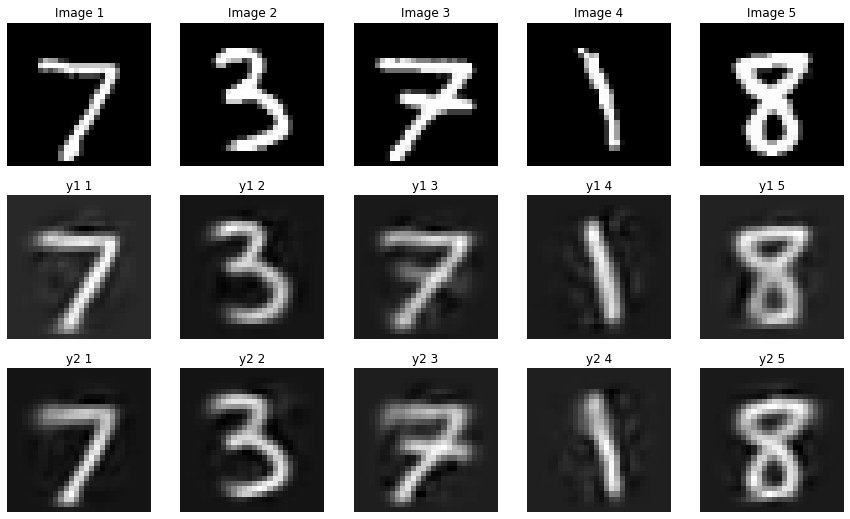

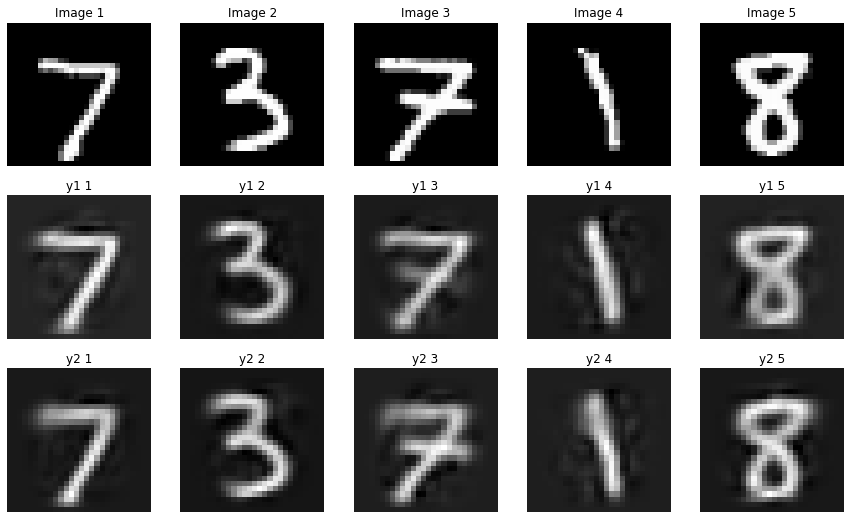

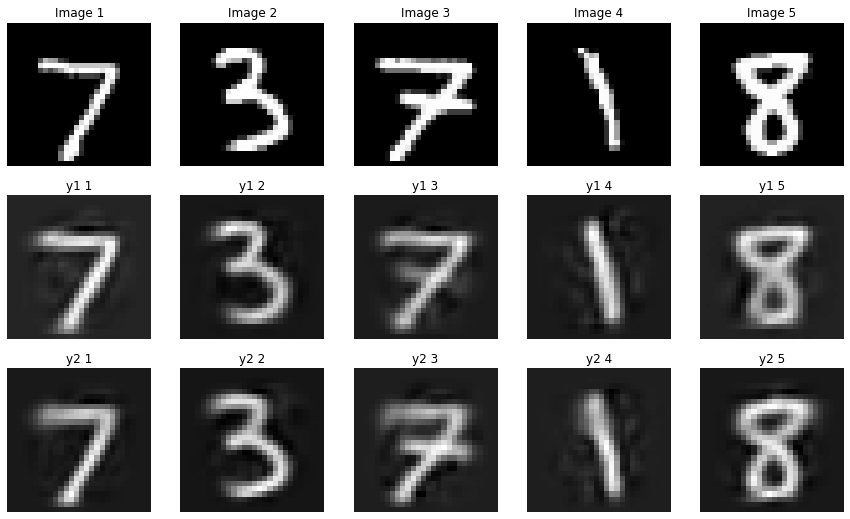

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/nrun1_snr_-40/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.8817, 0.6581, 0.6557
 Test PSNR: 9.5563, 10.8264, 10.8424


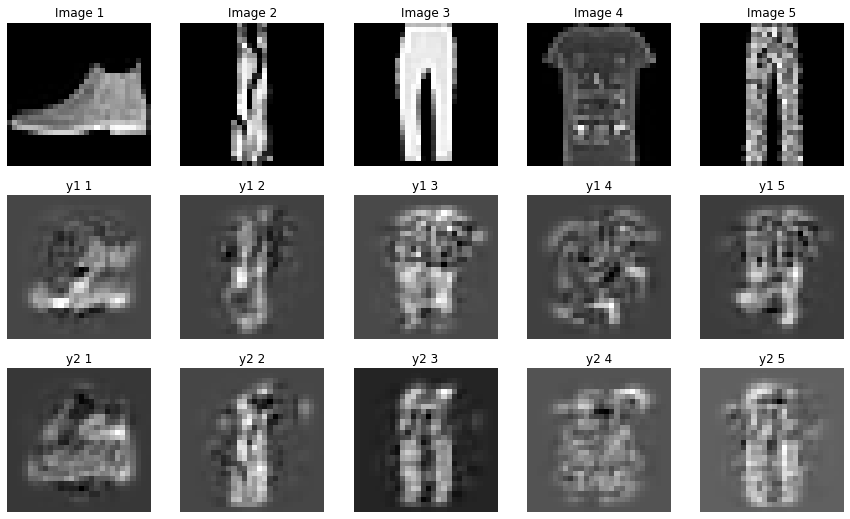

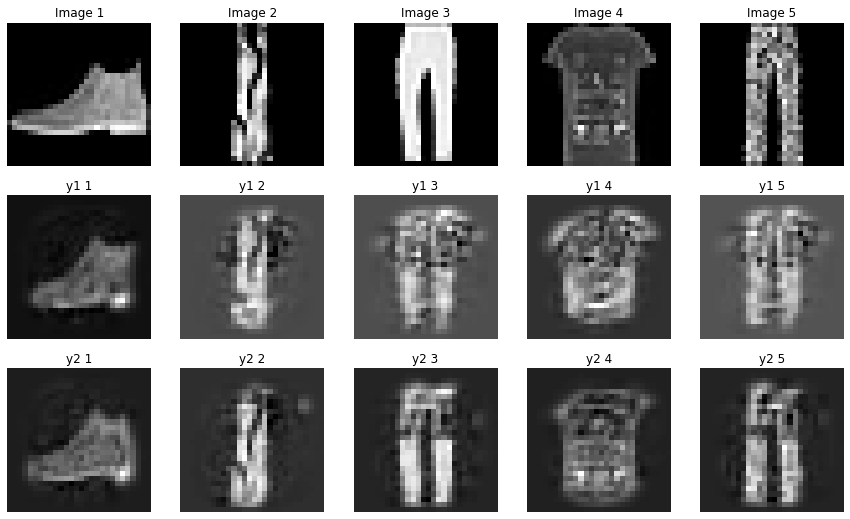

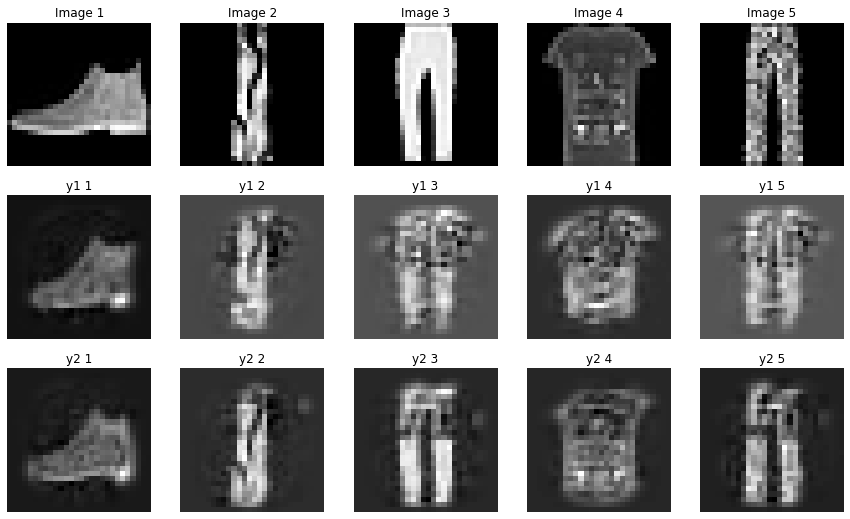

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/nrun1_snr_0/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

fashion_test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=fashion_transform, download=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=args.batch_size, shuffle=False)


result = test(model, fashion_test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(fashion_test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.2401, 0.0515, 0.0496
 Test PSNR: 15.2054, 21.8913, 22.0517


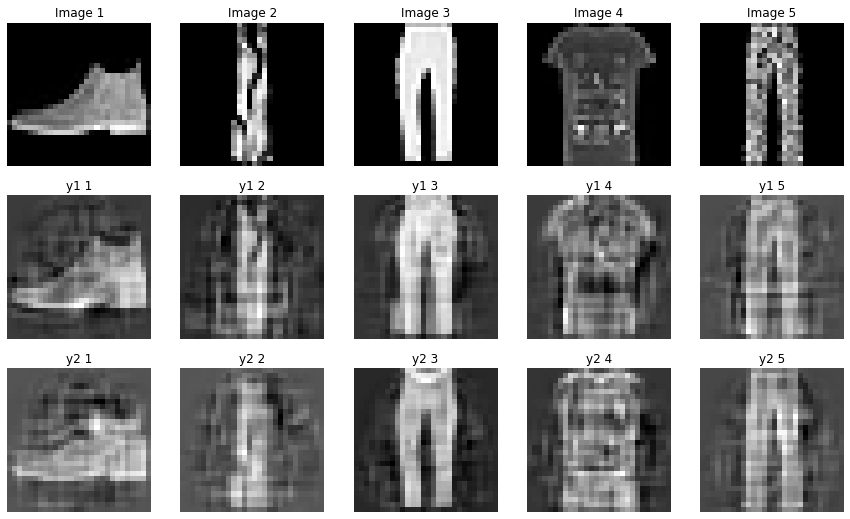

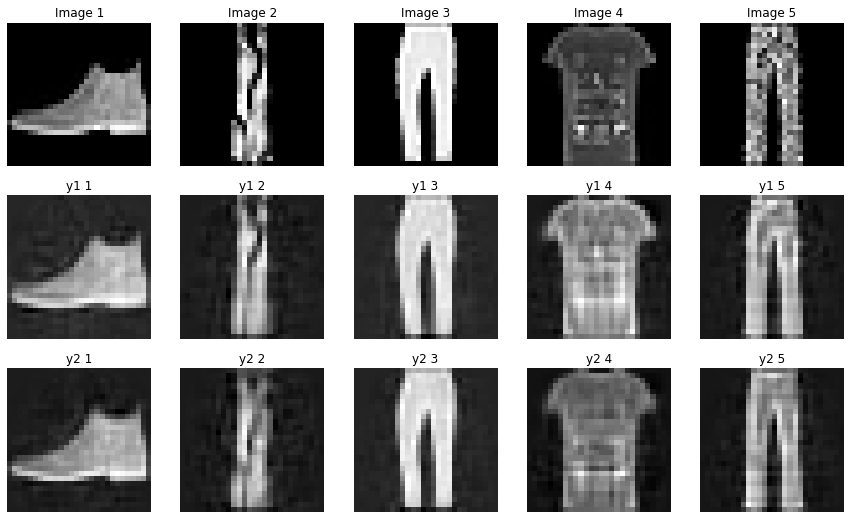

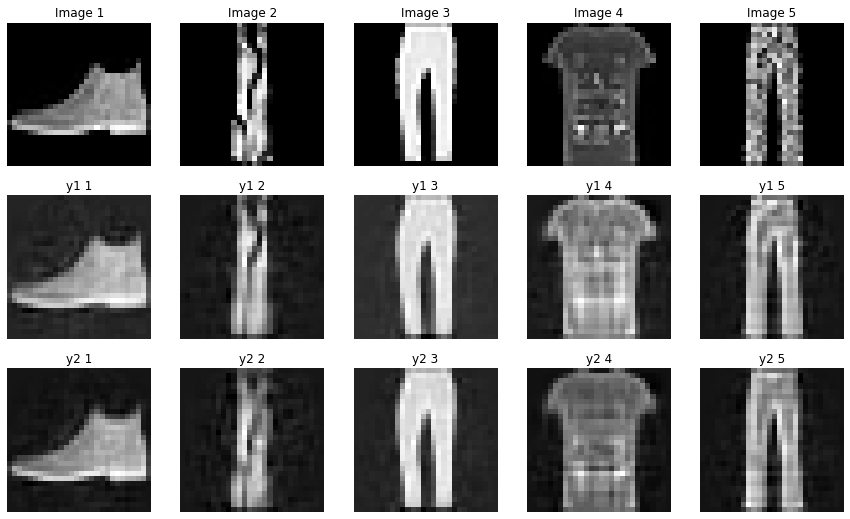

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])


model_path = 'models/fashion_run1_o256_h256snr_0/model.pt'
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

fashion_test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=fashion_transform, download=True)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=args.batch_size, shuffle=False)


result = test(model, fashion_test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(fashion_test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.4470, 0.0625, 0.0585
 Test PSNR: 12.5060, 21.0530, 21.3380


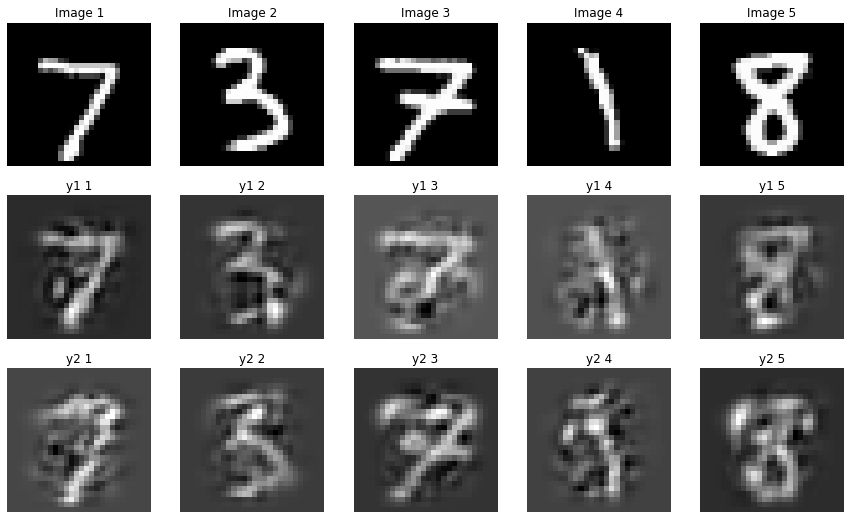

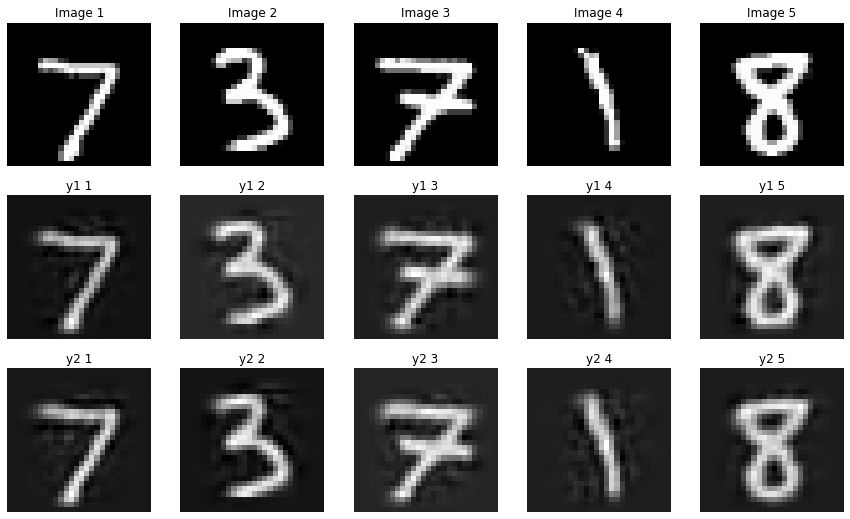

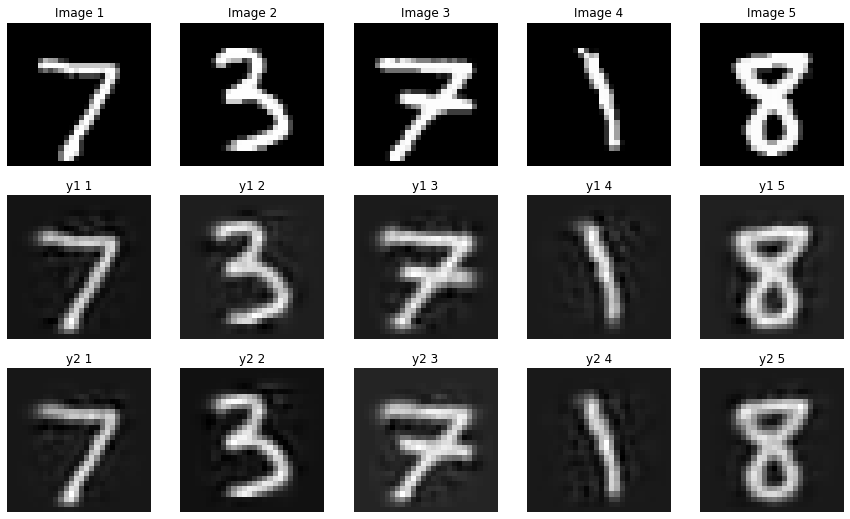

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

model2 = ButterflyNetwork(input_size, 128, 64, eq_train_sigma, scale_power).to(device)

model_path = 'models/nrun1_o64_h128_snr_0/model.pt'
if os.path.isfile(model_path):
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
result = test(model2, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        y1, y2, y_list = model2(x1, x2, noise_std_dev=sigma)
        # else:
        #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


Loaded model:
 SNR range: (-20.0, 0.0, 40.0)
 Test Loss: 0.4466, 0.0625, 0.0585
 Test PSNR: 12.5105, 21.0530, 21.3380


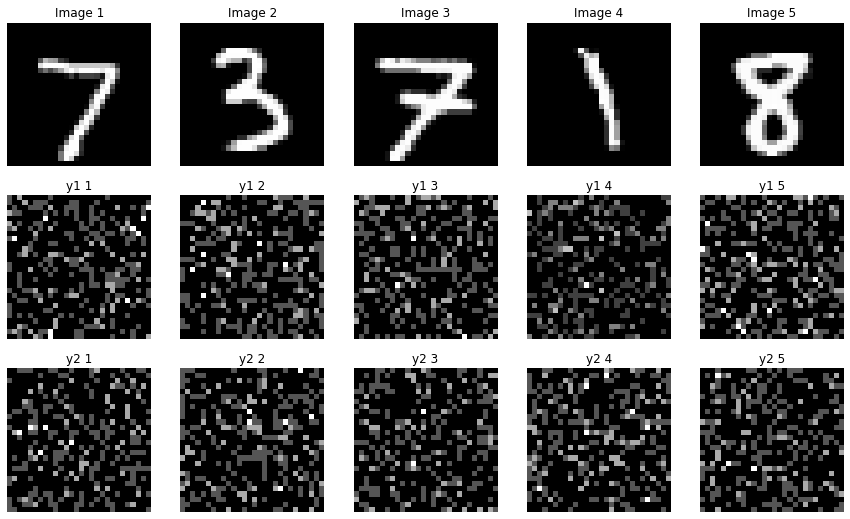

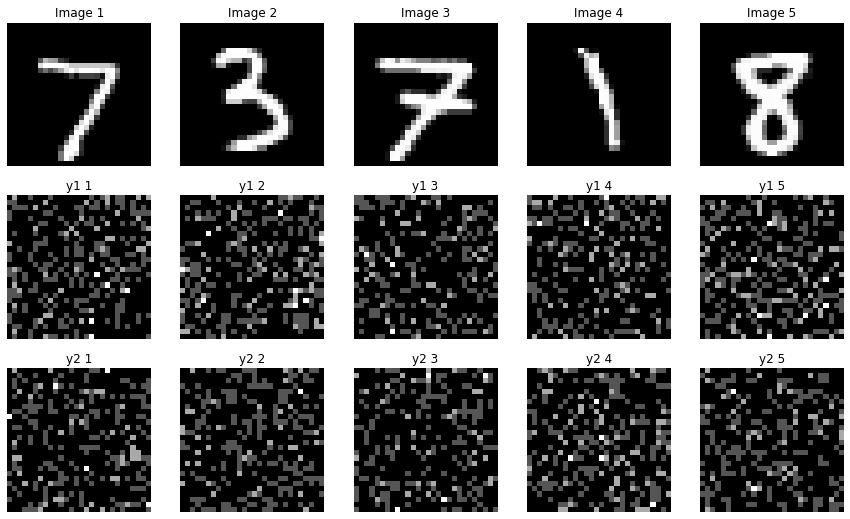

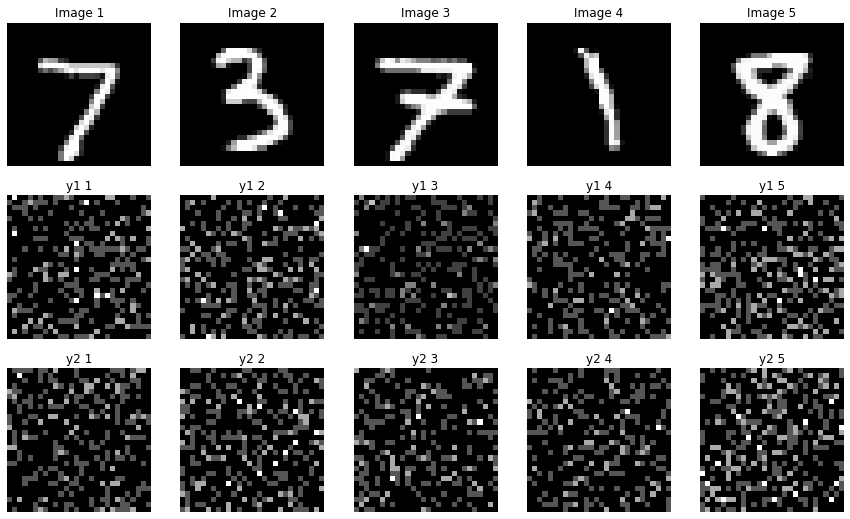

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

model2 = ButterflyNetwork(input_size, 128, 64, eq_train_sigma, scale_power).to(device)

model_path = 'models/nrun1_o64_h128_snr_0/model.pt'
if os.path.isfile(model_path):
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
result = test(model2, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"Loaded model:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")



for snr in [-20, 0, 40]:
    # Sample 5 images from the dataloader
    sample_images = []
    sample_y1s = []
    sample_y2s = []

    # snr = 0
    power = 1
    sigma = snr_db2sigma(snr) / np.sqrt(power)
    for i, (images, labels) in enumerate(test_loader):
        if i >= 5:
            break

        height = images.size(2)
        mid_point = height // 2

        x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
        x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

        # if not quantize:
        # y1, y2, y_list = model2(x1, x2, noise_std_dev=sigma)
        # else:
        num_bits = 8
        y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

        sample_images.append(to_numpy_image(images[0]))
        sample_y1s.append(to_numpy_image(y1[0]))
        sample_y2s.append(to_numpy_image(y2[0]))

    # Visualize the images, y1, and y2 on a 3x5 grid
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))

    for i in range(5):
        axes[0, i].imshow(sample_images[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Image {i+1}')

        axes[1, i].imshow(sample_y1s[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'y1 {i+1}')

        axes[2, i].imshow(sample_y2s[i], cmap='gray')
        axes[2, i].axis('off')
        axes[2, i].set_title(f'y2 {i+1}')

    plt.show()


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

model2 = ButterflyNetwork(input_size, 128, 64, eq_train_sigma, scale_power).to(device)

model_path = 'models/scale_0.007_run1_snr_40_h64_o32/model.pt'
ptest_losses = [] 
ptest_psnrs = []
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, power).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    ptest_losses.extend(test_losses)
    ptest_psnrs.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

model_path = 'models/noscale_0.007_run1_snr_40_h64_o32/model.pt'
ptest_losses2 = [] 
ptest_psnrs2 = []
powers = [0.0007, 0.007, 0.07, 0.7, 7]
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)/power**0.5], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    ptest_losses2.extend(test_losses)
    ptest_psnrs2.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")


# for snr in [-20, 0, 40]:
#     # Sample 5 images from the dataloader
#     sample_images = []
#     sample_y1s = []
#     sample_y2s = []

#     # snr = 0
#     power = 1
#     sigma = snr_db2sigma(snr) / np.sqrt(power)
#     for i, (images, labels) in enumerate(test_loader):
#         if i >= 5:
#             break

#         height = images.size(2)
#         mid_point = height // 2

#         x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
#         x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

#         # if not quantize:
#         # y1, y2, y_list = model2(x1, x2, noise_std_dev=sigma)
#         # else:
#         num_bits = 8
#         y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

#         sample_images.append(to_numpy_image(images[0]))
#         sample_y1s.append(to_numpy_image(y1[0]))
#         sample_y2s.append(to_numpy_image(y2[0]))

#     # Visualize the images, y1, and y2 on a 3x5 grid
#     fig, axes = plt.subplots(3, 5, figsize=(15, 9))

#     for i in range(5):
#         axes[0, i].imshow(sample_images[i], cmap='gray')
#         axes[0, i].axis('off')
#         axes[0, i].set_title(f'Image {i+1}')

#         axes[1, i].imshow(sample_y1s[i], cmap='gray')
#         axes[1, i].axis('off')
#         axes[1, i].set_title(f'y1 {i+1}')

#         axes[2, i].imshow(sample_y2s[i], cmap='gray')
#         axes[2, i].axis('off')
#         axes[2, i].set_title(f'y2 {i+1}')

#     plt.show()


Power: 0.0007 
 Test Loss: 0.9912
 Test PSNR: 9.0479
Power: 0.007 
 Test Loss: 0.6021
 Test PSNR: 11.2127
Power: 0.07 
 Test Loss: 351702.3838
 Test PSNR: -46.4522
Power: 0.7 
 Test Loss: 34227204820560.1523
 Test PSNR: -126.3342
Power: 7 
 Test Loss: 3434796425848318066688.0000
 Test PSNR: -206.3494
Power: 0.0007 
 Test Loss: 0.1278
 Test PSNR: 17.9440
Power: 0.007 
 Test Loss: 0.1088
 Test PSNR: 18.6435
Power: 0.07 
 Test Loss: 0.1069
 Test PSNR: 18.7188
Power: 0.7 
 Test Loss: 0.1067
 Test PSNR: 18.7265
Power: 7 
 Test Loss: 0.1067
 Test PSNR: 18.7272


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

model2 = ButterflyNetwork(input_size, 128, 64, eq_train_sigma, scale_power).to(device)

model_path = 'models/scale_7_run1_snr_40_h64_o32/model.pt'
p7test_losses = [] 
p7test_psnrs = []
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, power).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    p7test_losses.extend(test_losses)
    p7test_psnrs.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

model_path = 'models/noscale_7_run1_snr_40_h64_o32/model.pt'
p7test_losses2 = [] 
p7test_psnrs2 = []
powers = [0.0007, 0.007, 0.07, 0.7, 7]
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)/power**0.5], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    p7test_losses2.extend(test_losses)
    p7test_psnrs2.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")




Power: 0.0007 
 Test Loss: 1.0159
 Test PSNR: 8.9411
Power: 0.007 
 Test Loss: 1.0154
 Test PSNR: 8.9430
Power: 0.07 
 Test Loss: 1.0114
 Test PSNR: 8.9603
Power: 0.7 
 Test Loss: 1.0004
 Test PSNR: 9.0078
Power: 7 
 Test Loss: 0.1063
 Test PSNR: 18.7461
Power: 0.0007 
 Test Loss: 0.4614
 Test PSNR: 12.3691
Power: 0.007 
 Test Loss: 0.1416
 Test PSNR: 17.4975
Power: 0.07 
 Test Loss: 0.1092
 Test PSNR: 18.6261
Power: 0.7 
 Test Loss: 0.1060
 Test PSNR: 18.7566
Power: 7 
 Test Loss: 0.1057
 Test PSNR: 18.7698


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,0,40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

model2 = ButterflyNetwork(input_size, 128, 64, eq_train_sigma, scale_power).to(device)

model_path = 'models/scale_0.007_run1_snr_40_h64_o32/model.pt'
ptest_losses = [] 
ptest_psnrs = []
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, power).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    ptest_losses.extend(test_losses)
    ptest_psnrs.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")

model_path = 'models/noscale_0.007_run1_snr_40_h64_o32/model.pt'
ptest_losses2 = [] 
ptest_psnrs2 = []
powers = [0.0007, 0.007, 0.07, 0.7, 7]
for power in [0.0007, 0.007, 0.07, 0.7, 7]:
    model2 = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)
    model2.load_state_dict(torch.load(model_path, map_location=device))
    model2.eval()
    result = test(model2, test_loader, [snr_db2sigma(40)/power**0.5], device)
    snr_range, test_losses, test_psnrs = zip(*result)
    ptest_losses2.extend(test_losses)
    ptest_psnrs2.extend(test_psnrs)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"Power: {power} \n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")




Power: 0.0007 
 Test Loss: 0.9912
 Test PSNR: 9.0479
Power: 0.007 
 Test Loss: 0.6021
 Test PSNR: 11.2126
Power: 0.07 
 Test Loss: 351637.2271
 Test PSNR: -46.4514
Power: 0.7 
 Test Loss: 34227723339717.1133
 Test PSNR: -126.3342
Power: 7 
 Test Loss: 3434794902466175434752.0000
 Test PSNR: -206.3494
Power: 0.0007 
 Test Loss: 0.1279
 Test PSNR: 17.9420
Power: 0.007 
 Test Loss: 0.1088
 Test PSNR: 18.6425
Power: 0.07 
 Test Loss: 0.1069
 Test PSNR: 18.7186
Power: 0.7 
 Test Loss: 0.1067
 Test PSNR: 18.7265
Power: 7 
 Test Loss: 0.1067
 Test PSNR: 18.7273


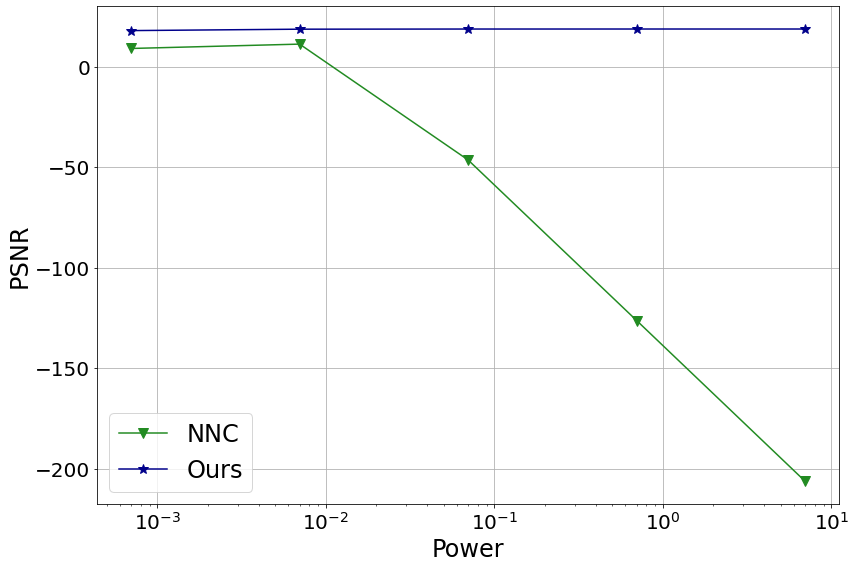

In [21]:
import matplotlib.pyplot as plt
powers = [0.0007, 0.007, 0.07, 0.7, 7]

plt.figure(figsize=(12,8))

plt.plot(powers, ptest_psnrs, color='forestgreen', marker='v', linestyle='-', markersize=10, label='NNC')
plt.plot(powers, ptest_psnrs2, color='darkblue', marker='*', linestyle='-', markersize=10, label='Ours')

plt.xlabel('Power', fontsize=24)
plt.ylabel('PSNR', fontsize=24)

plt.xscale('log')

plt.xticks(fontsize=20)  # Increase xtick size
plt.yticks(fontsize=20)  # Increase ytick size

plt.legend(fontsize=24)
plt.grid()

plt.tight_layout()  # Adjust the layout for better spacing

plt.savefig('figures/snr_new.pdf', bbox_inches='tight')  # Save figure with tight bounding box


In [16]:
ls figures

psnr_vs_power_7.eps  psnr_vs_power_p007.eps


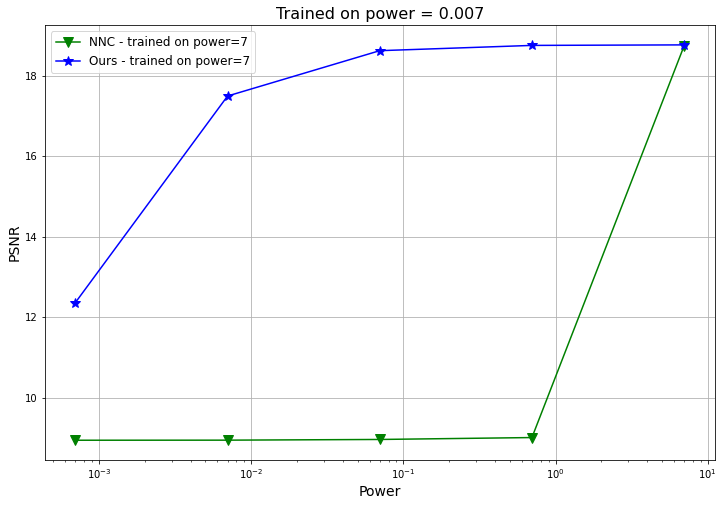

In [9]:
powers = [0.0007, 0.007, 0.07, 0.7, 7]

plt.figure(figsize=(12,8))

plt.plot(powers, ptest_psnrs, color='green', marker='v', linestyle='-', markersize=10, label='NNC - trained on power=7')
plt.plot(powers, ptest_psnrs2, color='blue', marker='*', linestyle='-', markersize=10, label='Ours - trained on power=7')

# plt.title('Trained on power = 0.007', fontsize=16)
plt.xlabel('Power', fontsize=1)
plt.ylabel('PSNR', fontsize=14)

plt.xscale('log')

plt.legend(fontsize=12)
plt.grid()

# plt.show()
plt.savefig('figures/psnr_vs_power_7_new.pdf')



In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-50, -40, -30, -20,-10, 0,10, 20, 30, 40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

psnrs = {}
for train_snr in [-40, -30, -20, -10, 0, 10, 20, 30, 40]:
    model_path = f'models/nrun1_snr_{train_snr}/model.pt'
    train_sigma = snr_db2sigma(train_snr)
    model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)
    
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    result = test(model, test_loader, eq_test_sigma, device)
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
    psnrs[train_snr] = test_psnrs



# for snr in [-20, 0, 40]:
#     # Sample 5 images from the dataloader
#     sample_images = []
#     sample_y1s = []
#     sample_y2s = []

#     # snr = 0
#     power = 1
#     sigma = snr_db2sigma(snr) / np.sqrt(power)
#     for i, (images, labels) in enumerate(test_loader):
#         if i >= 5:
#             break

#         height = images.size(2)
#         mid_point = height // 2

#         x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
#         x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

#         # if not quantize:
#         y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
#         # else:
#         #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

#         # sample_images.append(to_numpy_image(images[0]))
#         # sample_y1s.append(to_numpy_image(y1[0]))
#         # sample_y2s.append(to_numpy_image(y2[0]))

#     # # Visualize the images, y1, and y2 on a 3x5 grid
#     # fig, axes = plt.subplots(3, 5, figsize=(15, 9))

#     # for i in range(5):
#     #     axes[0, i].imshow(sample_images[i], cmap='gray')
#     #     axes[0, i].axis('off')
#     #     axes[0, i].set_title(f'Image {i+1}')

#     #     axes[1, i].imshow(sample_y1s[i], cmap='gray')
#     #     axes[1, i].axis('off')
#     #     axes[1, i].set_title(f'y1 {i+1}')

#     #     axes[2, i].imshow(sample_y2s[i], cmap='gray')
#     #     axes[2, i].axis('off')
#     #     axes[2, i].set_title(f'y2 {i+1}')

#     # plt.show()


train SNR : -40:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 0.7007, 0.1920, 0.1468, 0.1426, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422, 0.1422
 Test PSNR: 10.5543, 16.1771, 17.3410, 17.4672, 17.4802, 17.4814, 17.4815, 17.4816, 17.4816, 17.4816
train SNR : -30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 2.7958, 0.3274, 0.0939, 0.0738, 0.0719, 0.0717, 0.0717, 0.0717, 0.0717, 0.0717
 Test PSNR: 4.5445, 13.8593, 19.2812, 20.3279, 20.4409, 20.4530, 20.4542, 20.4543, 20.4543, 20.4543
train SNR : -20:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 11.0148, 1.1480, 0.1531, 0.0593, 0.0504, 0.0495, 0.0494, 0.0494, 0.0494, 0.0494
 Test PSNR: -1.4102, 8.4100, 17.1604, 21.2821, 21.9850, 22.0609, 22.0685, 22.0693, 22.0694, 22.0694
train SNR : -10:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 39.5414, 4.1902, 0.4842, 0.0820, 0.04

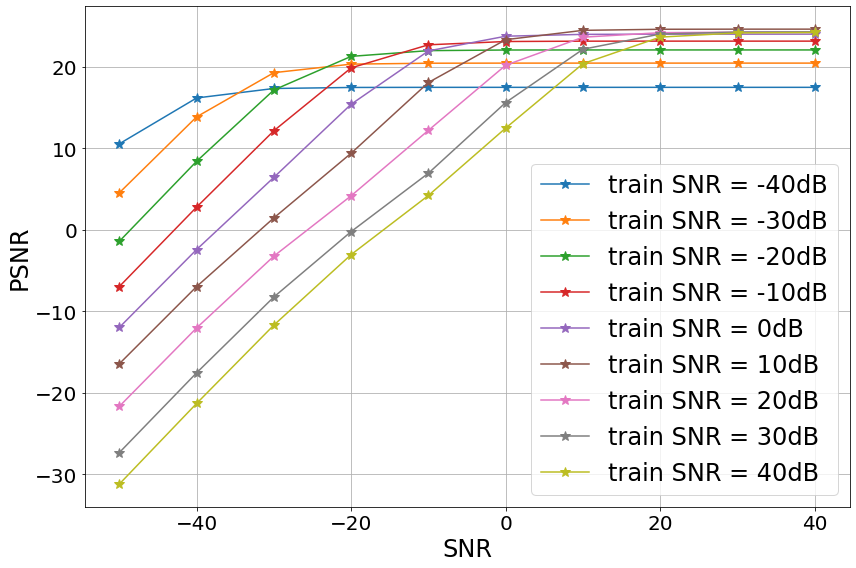

In [22]:
# plot all
plt.figure(figsize=(12,8))
for snr, ps in psnrs.items():
    plt.plot(snr_range, ps, marker='*', linestyle='-', markersize=10, label=f'train SNR = {snr}dB')
# plt.title('Performance comparison of NNC and Ours', fontsize=16)
plt.xlabel('SNR', fontsize=24)
plt.ylabel('PSNR', fontsize=24)
plt.legend(fontsize=24)
plt.xticks(fontsize=20)  # Increase xtick size
plt.yticks(fontsize=20)  # Increase ytick size
plt.grid()
plt.tight_layout()  # Adjust the layout for better spacing
plt.savefig('figures/snr_all.pdf', bbox_inches='tight')


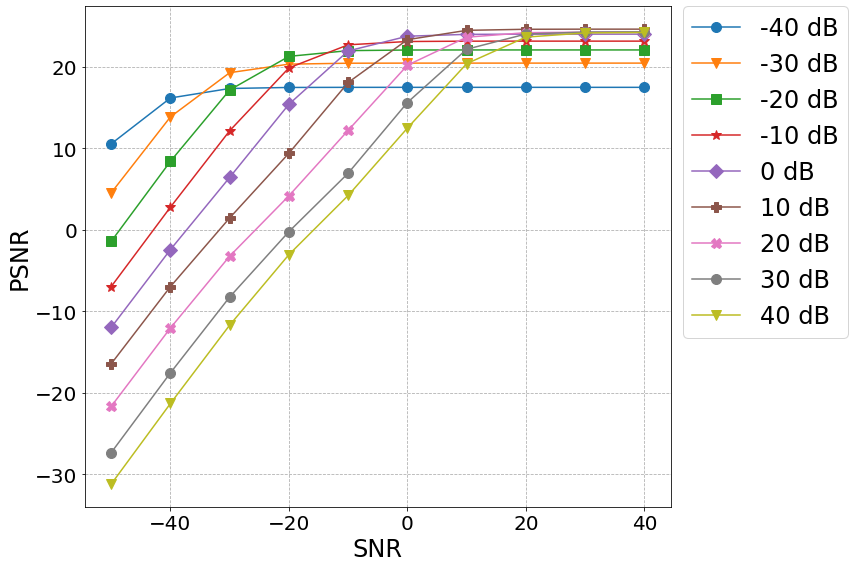

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

marker_styles = ['o', 'v', 's', '*', 'D', 'P', 'X']  # Add different marker styles

for i, (snr, ps) in enumerate(psnrs.items()):
    plt.plot(snr_range, ps, marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=10, label=f'{snr} dB')

plt.xlabel('Test SNR', fontsize=24)
plt.ylabel('PSNR', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(which='both', linestyle='--')  # Add a dashed grid

# Move the legend outside the plot area
plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()  # Adjust the layout and leave space for the legend

plt.savefig('figures/snr_all.pdf', bbox_inches='tight')


In [36]:
model_path = f'models/run2_curriculum_0to40/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs['0to40'] = test_psnrs

model_path = f'models/run2_curriculum_40to0/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs['40to0'] = test_psnrs

model_path = f'models/run1_random_snr/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs['random'] = test_psnrs

train SNR : 40:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 969.4802, 107.0025, 14.5371, 2.7555, 0.4436, 0.0757, 0.0374, 0.0336, 0.0332, 0.0332
 Test PSNR: -20.8558, -11.2844, -2.6152, 4.6076, 12.5397, 20.2197, 23.2771, 23.7444, 23.7942, 23.7990
train SNR : 40:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 1136.6812, 124.0383, 16.5029, 3.0459, 0.5005, 0.0812, 0.0373, 0.0329, 0.0325, 0.0325
 Test PSNR: -21.5468, -11.9260, -3.1660, 4.1724, 12.0151, 19.9129, 23.2895, 23.8342, 23.8914, 23.8974
train SNR : 40:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 400.8179, 44.3260, 6.1081, 0.9813, 0.1351, 0.0407, 0.0313, 0.0304, 0.0303, 0.0303
 Test PSNR: -17.0199, -7.4570, 1.1505, 9.0917, 17.7030, 22.9149, 24.0483, 24.1787, 24.1922, 24.1934


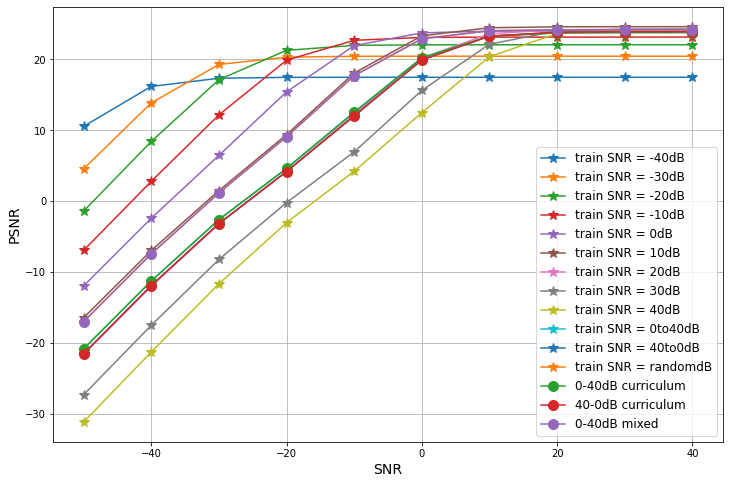

In [37]:
# plot all
plt.figure(figsize=(12,8))
for snr, ps in psnrs.items():
    plt.plot(snr_range, ps, marker='*', linestyle='-', markersize=10, label=f'train SNR = {snr}dB')
# plt.title('Performance comparison of NNC and Ours', fontsize=16)
plt.plot(snr_range, psnrs['0to40'], marker='o', linestyle='-', markersize=10, label=f'0-40dB curriculum')
plt.plot(snr_range, psnrs['40to0'], marker='o', linestyle='-', markersize=10, label=f'40-0dB curriculum')
plt.plot(snr_range, psnrs['random'], marker='o', linestyle='-', markersize=10, label=f'0-40dB mixed')
plt.xlabel('SNR', fontsize=14)
plt.ylabel('PSNR', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-20,-10, 0,10, 20, 30, 40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

psnrs = {}
psnrs_dropped = {}
for train_snr in [0, 10, 20, 30, 40]:
    model_path = f'models/nrun1_snr_{train_snr}/model.pt'
    train_sigma = snr_db2sigma(train_snr)
    model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)
    
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    result = test_dropped(model, test_loader, eq_test_sigma, device, dropped = ['AE'])
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
    psnrs[train_snr] = test_psnrs

    model_path = f'models/nrun1_drop_snr_{train_snr}/model.pt'
    train_sigma = snr_db2sigma(train_snr)
    model = ButterflyNetwork(input_size, 256, 256, train_sigma, 1).to(device)
    
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    result = test_dropped(model, test_loader, eq_test_sigma, device, dropped = ['AE'])
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
    psnrs_dropped[train_snr] = test_psnrs



# for snr in [-20, 0, 40]:
#     # Sample 5 images from the dataloader
#     sample_images = []
#     sample_y1s = []
#     sample_y2s = []

#     # snr = 0
#     power = 1
#     sigma = snr_db2sigma(snr) / np.sqrt(power)
#     for i, (images, labels) in enumerate(test_loader):
#         if i >= 5:
#             break

#         height = images.size(2)
#         mid_point = height // 2

#         x1 = images[:, :, :mid_point, :].reshape(images.size(0), -1).to(device)
#         x2 = images[:, :, mid_point:, :].reshape(images.size(0), -1).to(device)

#         # if not quantize:
#         y1, y2, y_list = model(x1, x2, noise_std_dev=sigma)
#         # else:
#         #     y1, y2, y_list = model.run_quantized(num_bits, x1, x2, noise_std_dev=sigma)

#         # sample_images.append(to_numpy_image(images[0]))
#         # sample_y1s.append(to_numpy_image(y1[0]))
#         # sample_y2s.append(to_numpy_image(y2[0]))

#     # # Visualize the images, y1, and y2 on a 3x5 grid
#     # fig, axes = plt.subplots(3, 5, figsize=(15, 9))

#     # for i in range(5):
#     #     axes[0, i].imshow(sample_images[i], cmap='gray')
#     #     axes[0, i].axis('off')
#     #     axes[0, i].set_title(f'Image {i+1}')

#     #     axes[1, i].imshow(sample_y1s[i], cmap='gray')
#     #     axes[1, i].axis('off')
#     #     axes[1, i].set_title(f'y1 {i+1}')

#     #     axes[2, i].imshow(sample_y2s[i], cmap='gray')
#     #     axes[2, i].axis('off')
#     #     axes[2, i].set_title(f'y2 {i+1}')

#     # plt.show()


train SNR : 0:
 SNR range: (-20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 0.5188, 0.3538, 0.3374, 0.3358, 0.3357, 0.3356, 0.3356
 Test PSNR: 11.8594, 13.5217, 13.7282, 13.7484, 13.7506, 13.7509, 13.7509
train SNR : 0:
 SNR range: (-20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 0.3184, 0.0806, 0.0569, 0.0545, 0.0543, 0.0543, 0.0543
 Test PSNR: 13.9803, 19.9484, 21.4600, 21.6441, 21.6628, 21.6646, 21.6648
train SNR : 10:
 SNR range: (-20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 1.0863, 0.4095, 0.3316, 0.3238, 0.3231, 0.3230, 0.3230
 Test PSNR: 8.6501, 12.8869, 13.8028, 13.9064, 13.9166, 13.9176, 13.9177
train SNR : 10:
 SNR range: (-20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 1.2022, 0.1853, 0.0688, 0.0572, 0.0560, 0.0559, 0.0559
 Test PSNR: 8.2100, 16.3303, 20.6364, 21.4389, 21.5269, 21.5355, 21.5364
train SNR : 20:
 SNR range: (-20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 2.9126, 0.7370, 0.4014, 0.3643, 0.3607, 0.3603, 0.3603
 Test PSNR: 4

In [59]:
psnrs_dropped

{}

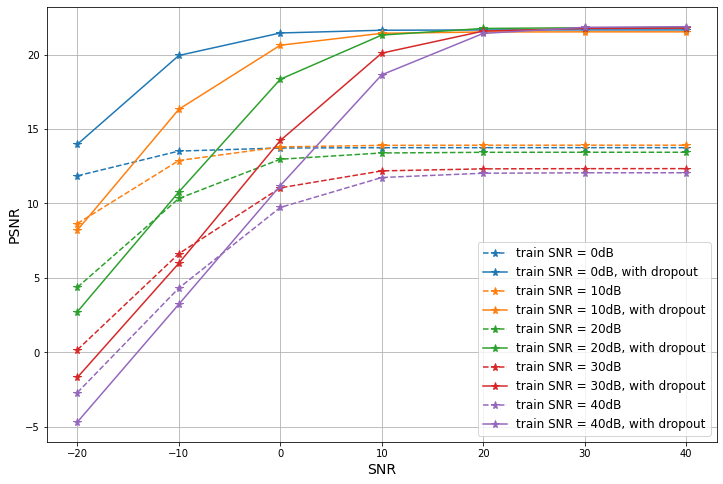

<Figure size 432x288 with 0 Axes>

In [20]:
import itertools

# plot all
plt.figure(figsize=(12, 8))

colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

for snr in psnrs.keys():
    color = next(colors)
    plt.plot(snr_range, psnrs[snr], marker='*', linestyle='dashed', markersize=8, label=f'train SNR = {snr}dB', color=color)
    plt.plot(snr_range, psnrs_dropped[snr], marker='*', linestyle='-', markersize=8, label=f'train SNR = {snr}dB, with dropout', color=color)

# plt.title('Performance comparison of NNC and Ours', fontsize=16)
plt.xlabel('SNR', fontsize=14)
plt.ylabel('PSNR', fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()
plt.savefig('figures/psnr_with_dropout.eps', format='eps', dpi=1000)


In [ ]:
import itertools
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
marker_styles = ['o', 'v', 's', '*', 'D', 'P', 'X']

# Create custom legend entries for dropout
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='dashed', lw=2),
                Line2D([0], [0], color='black', linestyle='-', lw=2)]

for i, snr in enumerate(psnrs.keys()):
    color = next(colors)
    plt.plot(snr_range, psnrs[snr], marker=marker_styles[i % len(marker_styles)], linestyle='dashed', markersize=8, label=f'{snr} dB', color=color)
    plt.plot(snr_range, psnrs_dropped[snr], marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=8, color=color)

plt.xlabel('SNR', fontsize=24)
plt.ylabel('PSNR', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid()

# Separate legends for SNR and dropout
legend1 = plt.legend(fontsize=24, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
legend2 = plt.legend(custom_lines, ['No dropout', 'With dropout'], fontsize=24, loc='upper left', bbox_to_anchor=(1.02, 0.6), borderaxespad=0)

plt.gca().add_artist(legend1)  # Add the first legend back after the second one is created

plt.tight_layout(rect=[0, 0, 0.8, 1])

plt.savefig('figures/psnr_with_dropout.pdf', bbox_inches='tight')


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert the image tensors back to NumPy arrays for visualization
def to_numpy_image(img_tensor):
    return img_tensor.detach().cpu().numpy().reshape(height, -1)

test_snr = [-50, -40, -30, -20,-10, 0,10, 20, 30, 40]
eq_test_sigma = np.array([snr_db2sigma(snr) for snr in test_snr])

psnrs = {}
for train_snr in [-30, 30]:
    model_path = f'models/run1_{train_snr}_o32_h64/model.pt'
    train_sigma = snr_db2sigma(train_snr)
    model = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)
    
    if os.path.isfile(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    result = test(model, test_loader, eq_test_sigma, device)
    snr_range, test_losses, test_psnrs = zip(*result)
    test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
    test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
    print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
    psnrs[train_snr] = test_psnrs

model_path = f'models/run1_curriculum_snr_-30_30/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs_m30_30 = test_psnrs

model_path = f'models/run2_curriculum_30_-30/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs_30_m30 = test_psnrs


train SNR : -30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 4.3123, 0.6143, 0.2285, 0.1922, 0.1887, 0.1884, 0.1883, 0.1883, 0.1883, 0.1883
 Test PSNR: 2.6625, 11.1260, 15.4212, 16.1719, 16.2521, 16.2597, 16.2607, 16.2607, 16.2607, 16.2607
train SNR : 30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 13458.7494, 1358.7958, 144.5728, 18.4360, 3.2886, 0.5304, 0.1474, 0.1087, 0.1048, 0.1044
 Test PSNR: -32.2805, -22.3220, -12.5913, -3.6471, 3.8394, 11.7632, 17.3235, 18.6479, 18.8057, 18.8220
train SNR : 30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 159.5694, 17.7768, 2.4205, 0.4093, 0.1417, 0.1133, 0.1105, 0.1102, 0.1102, 0.1102
 Test PSNR: -13.0199, -3.4890, 5.1705, 12.8893, 17.4965, 18.4661, 18.5766, 18.5877, 18.5888, 18.5889


RuntimeError: Error(s) in loading state_dict for ButterflyNetwork:
	size mismatch for A.layer1.weight: copying a param with shape torch.Size([64, 392]) from checkpoint, the shape in current model is torch.Size([256, 392]).
	size mismatch for A.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for A.layer2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for A.layer2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for A.batchnorm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for A.batchnorm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for A.batchnorm.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for A.batchnorm.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.layer1.weight: copying a param with shape torch.Size([64, 392]) from checkpoint, the shape in current model is torch.Size([256, 392]).
	size mismatch for B.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.layer2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for B.layer2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.batchnorm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.batchnorm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.batchnorm.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for B.batchnorm.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.layer1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for C.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.layer2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for C.layer2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.batchnorm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.batchnorm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.batchnorm.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for C.batchnorm.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.layer1.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for D.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.layer2.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for D.layer2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.batchnorm.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.batchnorm.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.batchnorm.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for D.batchnorm.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for E.layer1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for E.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for E.layer2.weight: copying a param with shape torch.Size([784, 64]) from checkpoint, the shape in current model is torch.Size([784, 256]).
	size mismatch for F.layer1.weight: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for F.layer1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for F.layer2.weight: copying a param with shape torch.Size([784, 64]) from checkpoint, the shape in current model is torch.Size([784, 256]).

In [7]:
model_path = f'models/run2_curriculum_30_-30/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs_30_m30 = test_psnrs

train SNR : 30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 15.7925, 2.2106, 0.4769, 0.2165, 0.1879, 0.1851, 0.1848, 0.1848, 0.1848, 0.1848
 Test PSNR: -2.9749, 5.5644, 12.2251, 15.6556, 16.2697, 16.3359, 16.3424, 16.3431, 16.3432, 16.3432


In [8]:
model_path = f'models/run1_random_snr_30_-30/model.pt'
train_sigma = snr_db2sigma(train_snr)
model = ButterflyNetwork(input_size, 64, 32, train_sigma, 1).to(device)

if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
result = test(model, test_loader, eq_test_sigma, device)
snr_range, test_losses, test_psnrs = zip(*result)
test_losses_str = ', '.join([f"{loss:.4f}" for loss in test_losses])
test_psnrs_str = ', '.join([f"{psnr:.4f}" for psnr in test_psnrs])
print(f"train SNR : {train_snr}:\n SNR range: {snr_range}\n Test Loss: {test_losses_str}\n Test PSNR: {test_psnrs_str}")
psnrs_random = test_psnrs

train SNR : 30:
 SNR range: (-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0)
 Test Loss: 5755.1009, 573.3659, 58.6876, 6.8136, 1.6134, 1.0858, 1.0314, 1.0256, 1.0249, 1.0249
 Test PSNR: -28.5910, -18.5748, -8.6759, 0.6758, 6.9320, 8.6522, 8.8753, 8.8999, 8.9025, 8.9028


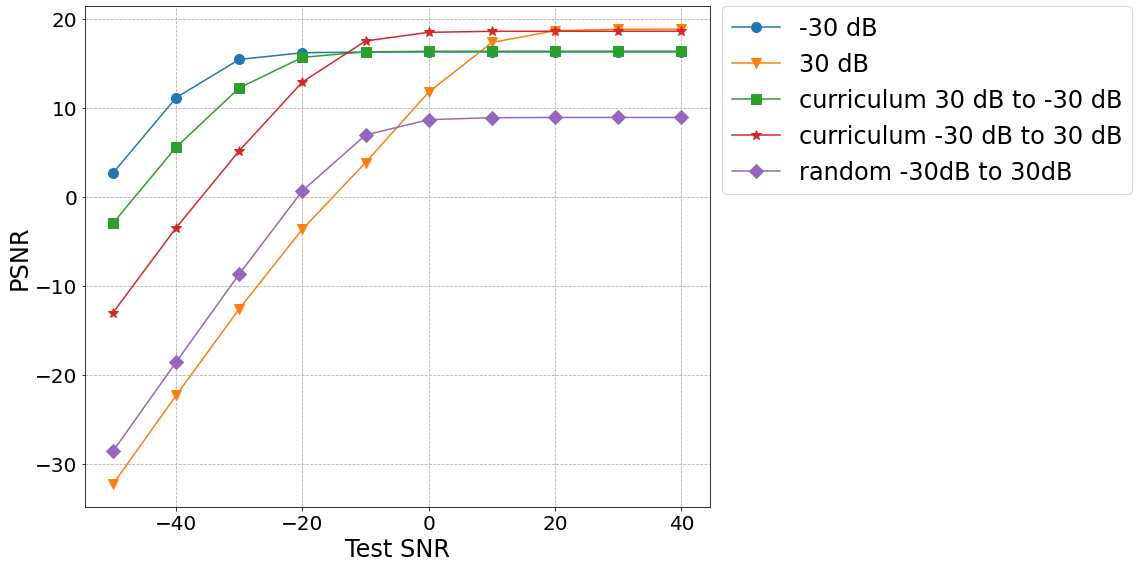

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))

marker_styles = ['o', 'v', 's', '*', 'D', 'P', 'X']  # Add different marker styles

for i, (snr, ps) in enumerate(psnrs.items()):
    plt.plot(snr_range, ps, marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=10, label=f'{snr} dB')

i += 1
plt.plot(snr_range, psnrs_30_m30, marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=10, label=f'curriculum 30 dB to -30 dB')
i += 1
plt.plot(snr_range, psnrs_m30_30, marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=10, label=f'curriculum -30 dB to 30 dB')
i += 1
plt.plot(snr_range, psnrs_random, marker=marker_styles[i % len(marker_styles)], linestyle='-', markersize=10, label=f'random -30dB to 30dB')

plt.xlabel('Test SNR', fontsize=24)
plt.ylabel('PSNR', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(which='both', linestyle='--')  # Add a dashed grid

# Move the legend outside the plot area
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

plt.tight_layout()  # Adjust the layout and leave space for the legend

plt.savefig('figures/snr_all.pdf', bbox_inches='tight')


In [9]:
psnrs

{-30: (2.662510573863983,
  11.12599492073059,
  15.421247482299805,
  16.171945333480835,
  16.252137422561646,
  16.25969648361206,
  16.26065492630005,
  16.260721683502197,
  16.26072645187378,
  16.260732412338257),
 30: (-32.2804856300354,
  -22.321982383728027,
  -12.591307163238525,
  -3.647112250328064,
  3.8394317030906677,
  11.763168573379517,
  17.32349157333374,
  18.64789843559265,
  18.805670738220215,
  18.821964263916016)}